# Lac Pavin proteome analysis

In [1]:
import matplotlib, re, os, glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess as sp
from collections import defaultdict
sns.set('notebook')
%matplotlib inline 
# hide warnings
import warnings
warnings.filterwarnings('ignore')
from Bio import SeqIO, SeqUtils, SearchIO

In [2]:
def cmdir(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def scaffold(gene):
    if gene != "None":
        try: return re.search("(.+?)_[0-9]+$", gene).group(1)
        except: print(gene)

def categorize(sample_name):
    if "SED" in sample_name:
        return "sediment"
    elif "12" in sample_name:
        return "shallow"
    elif "70" in sample_name or "90" in sample_name:
        return "anoxic zone"
    else: return "interface"

In [143]:
rootdir = "/groups/banfield/projects/environmental/LacPavin/analysis/"
cmdir(rootdir + "pclust")
adir = rootdir + "pclust/cpr/"
cmdir(adir)

In [144]:
merged_fasta = rootdir + "phylo/cpr/all_cpr_proteins.faa" #rootdir + "viral/protein/all_phage_proteins.faa" #
genome_dir = rootdir + "genomes/renamed_genomes/" #rootdir + "viral/genomes/integrated_genomes/" 

### run protein clustering

In [ ]:
with open(adir + "runProteinClustering.sh", "w") as wrapper:
    
    # start by subfamily clustering
    call1 = "/groups/banfield/users/meheurap/proteinClusteringPipeline/scripts/subfamilies.py --output-directory " + \
        adir + "protein_clustering/ --cpu 20 " + merged_fasta
    # then do hmm-hmm comparison to generate families
    call2 = "/groups/banfield/users/meheurap/proteinClusteringPipeline/scripts/hhblits.py --cpu 20 " + \
       adir + "/protein_clustering/config.json"
    call3 = "/home/meheurap/scripts/proteinClusteringPipeline/scripts/runningMclClustering.py --force --coverage 0.75 " + \
        "--fasta --cpu 20 " + adir + "/protein_clustering/config.json"
    wrapper.write("\n".join([call1,call2, call3]))

In [145]:
orf2family = {}
count = 0

for line in open(adir + "protein_clustering/orf2family.tsv").readlines():
    if count > 0:
        orf2family[line.split("\t")[0]] = line.split("\t")[1].strip()
    count +=1

In [146]:
# build scaf2bin
scaf2bin = {}

for genome in glob.glob(genome_dir + "/*"):
    name = os.path.basename(genome).replace(".fna", "")
    for record in SeqIO.parse(open(genome), "fasta"):
        scaf2bin[record.description.split(" ")[0]] = name

In [147]:
pdf = pd.DataFrame.from_dict(orf2family, orient="index").reset_index()
pdf.columns = ["gene", "family"]
pdf["bin"] = pdf["gene"].apply(lambda x: scaf2bin[scaffold(x)])
pdf.head()

,gene,family,bin
0,LacPavin_0818_WC45_scaffold_275807_1,fam4170,LacPavin_0818_WC45_Nomurabacteria_33_35
1,LacPavin_0818_WC45_scaffold_163443_128,fam4170,LacPavin_0818_WC45_Nomurabacteria_33_25
2,LacPavin_0818_WC45_scaffold_150134_61,fam3649,LacPavin_0818_WC45_Nomurabacteria_37_43
3,LacPavin_0818_WC45_scaffold_150134_62,fam3649,LacPavin_0818_WC45_Nomurabacteria_37_43
4,LacPavin_0818_WC45_scaffold_214961_13,fam3823,LacPavin_0818_WC45_Nomurabacteria_37_43


### run kofamscan

In [ ]:
# launch kofamscan
kocall = "sbatch -J kfscan --wrap '/shared/software/bin/exec_annotation -o " + adir + "/kofamscan.latest.txt " + \
    merged_fasta + " -p /shared/db/kegg/kofam/latest/profiles/prokaryote.hal " + \
    "-k /shared/db/kegg/kofam/latest/metadata/ko_list --cpu $SLURM_CPUS_ON_NODE -f detail'"
print(kocall)

In [148]:
# read in output
buffer = []
for line in open(adir + "kofamscan.latest.txt").readlines():
    if "#" not in line:
        # hilariously long regex
        m = re.search("[* ]*([\S]+)\s+([\S]+)\s+([0-9.-]+)\s+" + \
            "([0-9.-]+)\s+([0-9.+-e]+)\s(.+?$)", line.strip())
        try:
            buffer.append(m.groups())
        except:
            print(line)

kodf = pd.DataFrame.from_records(buffer, columns =["gene", "ko", "threshold", "score", "eval", "def"]) 
buffer=[]

In [149]:
# filter for significance
kodf["eval"] = kodf["eval"].apply(lambda x: float(x))
kodf["score"] = kodf["score"].apply(lambda x: float(x))
kodf = kodf[kodf["eval"] < 1e-6]
# get best hit per gene based on score
kfilt = kodf.sort_values('score', ascending=False).drop_duplicates("gene")
kfilt.head()

,gene,ko,threshold,score,eval,def
625987,LacPavin_0818_WC45_scaffold_276048_46,K13797,2919.43,2532.0,0.0,DNA-directed RNA polymerase subunit beta-beta'...
927019,LacPavin_0920_SED4_scaffold_1932365_1,K01952,641.60,1843.2,0.0,phosphoribosylformylglycinamidine synthase [EC...
564554,LacPavin_0818_WC45_scaffold_573185_16,K11540,3257.87,1752.4,0.0,carbamoyl-phosphate synthase / aspartate carba...
355750,LacPavin_0818_WC45_scaffold_417427_148,K11540,3257.87,1724.8,0.0,carbamoyl-phosphate synthase / aspartate carba...
746515,LacPavin_0920_SED5_scaffold_2007254_1,K03043,365.63,1652.3,0.0,DNA-directed RNA polymerase subunit beta [EC:2...


In [150]:
kodf = []

### reconcile

In [151]:
fam2ko = {}

for i, fam in enumerate(glob.glob(adir + "/protein_clustering/familiesFasta/*")):
    
    orfs = []
    for record in SeqIO.parse(open(fam), "fasta"):
        orfs.append(record.description.split(" ")[0])
        
    if len(orfs) >=10:
    
        table = kfilt[kfilt["gene"].isin(orfs)]

        if len(table) > 0:
            mode = table["ko"].mode()[0]
            p = table["ko"].to_list().count(mode)/float(len(orfs))
            fam2ko[os.path.basename(fam).replace(".fa","")] = {"ko": mode, "percent": round(p,3)}
            
    print('processed %d of %d families\r'%(i, len(glob.glob(adir + "/protein_clustering/familiesFasta/*"))), end="")

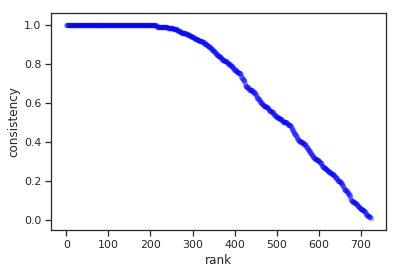

In [152]:
kps = [fam2ko[key]["percent"] for key in fam2ko.keys()]
kpf = pd.DataFrame(sorted(kps, reverse=True)).reset_index()
kpf.columns = ["rank", "consistency"]
sns.set_style("ticks")
kws = {'s':20, 'alpha':0.2}
sns.regplot("rank", "consistency", data=kpf, color="blue", scatter_kws=kws, fit_reg=False)
plt.show()

### setup metadata

In [286]:
def reclassify(row):
    
    detects = []
    for field in ["anoxic", "interface", "sediment"]:#, "shallow"]:
        if row[field] != 0:
            detects.append(field)
    return ",".join(sorted(detects))

In [304]:
# get order/ metadata
metadata = pd.read_csv(adir + "heatmap_info.tsv", sep="\t")
metadata["category"] = metadata.apply(reclassify, axis=1)
metadata = metadata.sort_values("category")
metadata.head()

,genome,anoxic,interface,sediment,position,lineage,color,category
52,LacPavin_0419_WC90_Gottesmanbacteria_46_6,0.001783,0.0,0.0,52,Microgenomates,#cde6c4,anoxic
53,LacPavin_0419_WC90_Taylorbacteria_44_7,0.001541,0.0,0.0,53,Parcubacteria_4,#fcf6b5,anoxic
51,LacPavin_0920_WC90_Shapirobacteria_39_8,0.002965,0.0,0.0,51,Microgenomates,#cde6c4,anoxic
25,LacPavin_0419_WC70L_Vogelbacteria_42_5,0.002302,0.0,0.0,25,Parcubacteria_4,#fcf6b5,anoxic
50,LacPavin_0419_WC90_Berkelbacteria_42_10,0.002812,0.0,0.0,50,Berkelbacteria,#facee1,anoxic


### find differentially distributed families

In [157]:
import scipy.stats as spstats
from statsmodels.stats.multitest import multipletests

In [158]:
# add in category info
pmerged = pdf.merge(metadata[["genome", "category"]], how="left", left_on="bin", right_on="genome")
pmerged.head()

,gene,family,bin,genome,category
0,LacPavin_0818_WC45_scaffold_275807_1,fam4170,LacPavin_0818_WC45_Nomurabacteria_33_35,LacPavin_0818_WC45_Nomurabacteria_33_35,interface
1,LacPavin_0818_WC45_scaffold_163443_128,fam4170,LacPavin_0818_WC45_Nomurabacteria_33_25,LacPavin_0818_WC45_Nomurabacteria_33_25,interface
2,LacPavin_0818_WC45_scaffold_150134_61,fam3649,LacPavin_0818_WC45_Nomurabacteria_37_43,LacPavin_0818_WC45_Nomurabacteria_37_43,interface
3,LacPavin_0818_WC45_scaffold_150134_62,fam3649,LacPavin_0818_WC45_Nomurabacteria_37_43,LacPavin_0818_WC45_Nomurabacteria_37_43,interface
4,LacPavin_0818_WC45_scaffold_214961_13,fam3823,LacPavin_0818_WC45_Nomurabacteria_37_43,LacPavin_0818_WC45_Nomurabacteria_37_43,interface


In [162]:
diffs = defaultdict(list)

for blah in ["blah"]:
    
    pvals = [] 
    table = pmerged
        
    for i, fam in enumerate(table["family"].unique()):

        subtable = table[table["family"]==fam]

        # implement min size
        if len(subtable) >= 5:

            # presence/absence
            subtable = subtable.drop_duplicates(["bin", "category"])

            for combo in ["interface", "sediment", "anoxic"]:

                if combo != "None":

                    diffs["fam"].append(fam)
                    diffs["combo"].append(combo)

                    in_num = len(subtable[subtable["category"].str.contains(combo)])
                    in_total = len(metadata[metadata["category"].str.contains(combo)])
                    out_num = len(subtable[~subtable["category"].str.contains(combo)])
                    out_total = len(metadata[~metadata["category"].str.contains(combo)])
                    diffs["in_num"].append(in_num)
                    diffs["in_perc"].append(in_num/in_total)
                    diffs["out_num"].append(out_num)
                    diffs["out_perc"].append(out_num/out_total)

                    if out_num == 0: # if exclusive
                        diffs["ratio"].append("None")
                        diffs["exclusive"].append(True)
                    else: # if not exclusive
                        diffs["ratio"].append((in_num/in_total)/(out_num/out_total))
                        diffs["exclusive"].append(False)

                    # compute fisher's exact statistic
                    contable = [[in_num, out_num], [in_total-in_num, out_total-out_num]]
                    oddsratio, pvalue = spstats.fisher_exact(contable, alternative='two-sided')
                    diffs["fisher_exact"].append(pvalue)
                    pvals.append(pvalue)

        print('processed %d of %d families\r'%(i, len(table["family"].unique())), end="")
            
    #fdr correction
    diffs["fisher_fdr"] += list(multipletests(pvals, method="fdr_bh")[1])

In [164]:
diffdf = pd.DataFrame(diffs)
diffdf = diffdf.merge(pd.DataFrame.from_dict(fam2ko, orient="index").reset_index().rename(columns={"index":"fam"}), how="left")
diffdf = diffdf.merge(kfilt[["ko", "def"]].drop_duplicates(), how="left").fillna("None")

In [186]:
diffdf.query("exclusive==False").sort_values("fisher_fdr", ascending=True).query("fisher_fdr<=0.05").query("ratio>=3")

,fam,combo,in_num,in_perc,out_num,out_perc,ratio,exclusive,fisher_exact,fisher_fdr,ko,percent,def
2370,fam3910,interface,30,0.576923,1,0.018519,31.153846,False,2.827338e-11,1.273150e-07,K03734,1.0,FAD:protein FMN transferase [EC:2.7.1.180]
231,fam0175,interface,30,0.576923,2,0.037037,15.576923,False,3.454019e-10,7.776724e-07,K03386,0.426,peroxiredoxin (alkyl hydroperoxide reductase s...
3558,fam3605,interface,31,0.596154,5,0.092593,6.438462,False,3.390581e-08,5.089263e-05,K03177,1.0,tRNA pseudouridine55 synthase [EC:5.4.99.25]
3423,fam0464,interface,20,0.384615,1,0.018519,20.769231,False,9.437243e-07,8.499181e-04,K00104,0.962,glycolate oxidase [EC:1.1.3.15]
984,fam0371,interface,27,0.519231,5,0.092593,5.607692,False,1.671768e-06,1.075424e-03,K03972,0.452,phage shock protein E
2832,fam0455,interface,19,0.365385,1,0.018519,19.730769,False,2.350343e-06,1.322949e-03,K17363,0.565,urocanate reductase [EC:1.3.99.33]
1749,fam4250,interface,21,0.403846,2,0.037037,10.903846,False,2.948678e-06,1.475322e-03,K07305,1.0,peptide-methionine (R)-S-oxide reductase [EC:1...
2728,fam0734,sediment,13,0.406250,3,0.040541,10.020833,False,6.463394e-06,2.602972e-03,K09141,1.0,uncharacterized protein
618,fam3449,interface,22,0.423077,4,0.074074,5.711538,False,3.044113e-05,8.567274e-03,K07304,0.923,peptide-methionine (S)-S-oxide reductase [EC:1...
1230,fam1223,interface,27,0.519231,8,0.148148,3.504808,False,6.683888e-05,1.458716e-02,K00027,1.0,malate dehydrogenase (oxaloacetate-decarboxyla...


In [187]:
diffdf.query("exclusive==True").sort_values("fisher_exact", ascending=True).query("fisher_fdr<=0.05")

,fam,combo,in_num,in_perc,out_num,out_perc,ratio,exclusive,fisher_exact,fisher_fdr,ko,percent,def
4329,fam2120,interface,18,0.346154,0,0.0,None,True,4.420752e-07,0.000498,None,None,None
1716,fam2167,interface,14,0.269231,0,0.0,None,True,1.673409e-05,0.005024,K09815,1.0,zinc transport system substrate-binding protein
3750,fam1438,interface,13,0.250000,0,0.0,None,True,3.990436e-05,0.010570,K03529,0.077,chromosome segregation protein
1032,fam0372,interface,12,0.230769,0,0.0,None,True,9.377524e-05,0.018360,K00928,0.917,aspartate kinase [EC:2.7.2.4]
4240,fam1866,sediment,7,0.218750,0,0.0,None,True,1.381143e-04,0.023034,None,None,None
2937,fam0750,interface,11,0.211538,0,0.0,None,True,2.172841e-04,0.031426,K07052,1.0,uncharacterized protein


In [336]:
# check for depletion
diffsub = diffdf[(diffdf["in_perc"]<=0.10) & (diffdf["out_perc"]>0.50)]
diffsub.sort_values("fisher_fdr", ascending=True).head(10)

,fam,combo,in_num,in_perc,out_num,out_perc,ratio,exclusive,fisher_exact,fisher_fdr,ko,percent,def


In [189]:
## write out 
diffdf.sort_values("fisher_fdr").to_csv(adir + "diffdf.tsv", sep="\t", index=False)

### protein family heatmap for cpr

In [341]:
cat_order = ["sediment", "anoxic,sediment", "anoxic", "anoxic,interface", "interface",
             "interface,sediment", "anoxic,interface,sediment"]

metadata["order"] = metadata["category"].apply(lambda x: cat_order.index(x))
metadata = metadata.sort_values("order").reset_index()
metadata["new_position"] = metadata.index
metadata=metadata.replace("lightgrey", "white")
metadata.head()

,level_0,index,genome,anoxic,interface,sediment,position,lineage,color,category,order,new_position
0,0,23,LacPavin_0920_SED1_CPR_39_9,0.0,0.0,0.008692,23,other,white,sediment,0,0
1,21,11,LacPavin_0920_SED5_Moranbacteria_41_12,0.0,0.0,0.002031,11,Moranbacteria,#bc80b8,sediment,0,1
2,19,7,LacPavin_0920_SED3_Nealsonbacteria_35_17,0.0,0.0,0.005026,7,Parcubacteria_2,#d9d9d8,sediment,0,2
3,18,8,LacPavin_0920_SED5_Azambacteria_40_7,0.0,0.0,0.000791,8,other,white,sediment,0,3
4,17,5,LacPavin_0920_SED5_Doudnabacteria_42_8,0.0,0.0,0.001176,5,other,white,sediment,0,4


In [342]:
# reconfigure protein counts
counts = pdf.groupby("family", as_index=False).aggregate({"gene":"count"})
to_keep = counts.query("gene>=5")["family"].to_list()
pdf_sub = pdf[pdf["family"].isin(to_keep)]
pdf_sub.head()

,gene,family,bin
7,LacPavin_0920_SED5_scaffold_113368_1,fam0479,LacPavin_0920_SED5_Parcubacteria_40_12
8,LacPavin_0419_WC70L_scaffold_180111_1,fam0479,LacPavin_0419_WC70L_Staskawiczbacteria_36_7
9,LacPavin_0920_WC90_scaffold_585232_133,fam0480,LacPavin_0920_WC90_Staskawiczbacteria_38_16
10,LacPavin_0818_WC45_scaffold_98893_199,fam0480,LacPavin_0818_WC45_Staskawiczbacteria_38_24
11,LacPavin_0920_SED2_scaffold_579421_30,fam0480,LacPavin_0920_SED2_Nealsonbacteria_39_9


In [343]:
pdf_dd = pdf_sub.drop_duplicates(["family", "bin"])
pdf_dd["value"] = 1
piv = pdf_dd.pivot("bin", "family", "value").fillna(0).reset_index()
piv = piv.merge(metadata[["genome", "new_position"]], how="left", left_on="bin", right_on="genome")
piv = piv.sort_values("new_position").drop(["bin", "genome", "new_position"], axis=1)
piv.tail()

,fam0001,fam0002,fam0003,fam0004,fam0005,fam0006,fam0007,fam0008,fam0009,fam0010,...,fam4343,fam4354,fam4355,fam4357,fam4361,fam4374,fam4385,fam4388,fam4400,fam4403
82,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
46,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [344]:
import math

# set up color bars
cmap = sns.light_palette("darkblue", as_cmap=True)

ccolors = {}
for key in ["interface", "anoxic", "sediment"]:
    colors=[cmap(100) if value !=0 else cmap(0) for value in metadata[key].to_list()]
    ccolors[key] = colors 
    
taxcolors = [item for item in metadata["color"].to_list()]

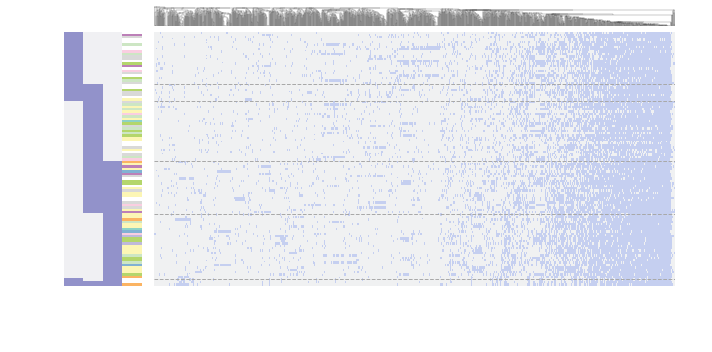

In [354]:
g = sns.clustermap(piv, figsize=(10,5), row_cluster=False, method='average', 
        metric='jaccard', cmap=sns.light_palette("#c5cff0", as_cmap=True), cbar_pos = None, dendrogram_ratio=0.07,
        row_colors=[ccolors["sediment"], ccolors["anoxic"], ccolors["interface"], taxcolors])
for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(0.25)

count = 0
current = "sediment"
for key, row in metadata.iterrows():
    if (row["category"] != current) & (row["category"]!='anoxic,interface,sediment'):
        plt.axhline(count, linewidth=1, color="darkgrey", ls="--")
    count+=1
    current = row["category"]

plt.axis("off")
plt.savefig(rootdir + "figures/cpr_proteome_heatmap.svg", format="svg")

### clustering within groups

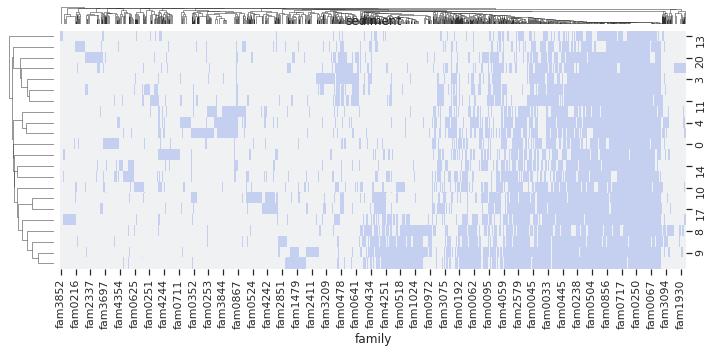

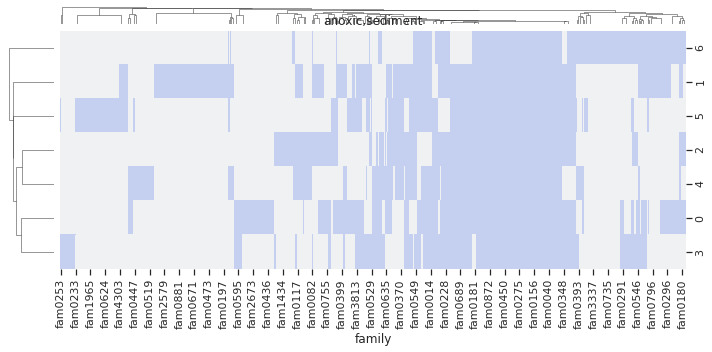

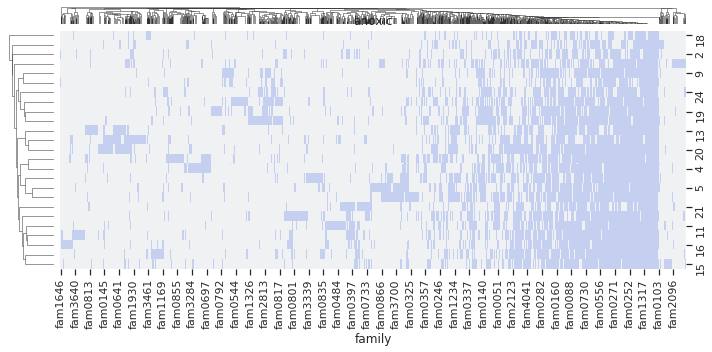

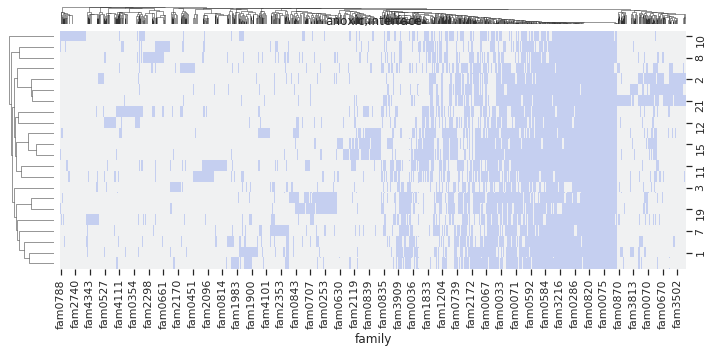

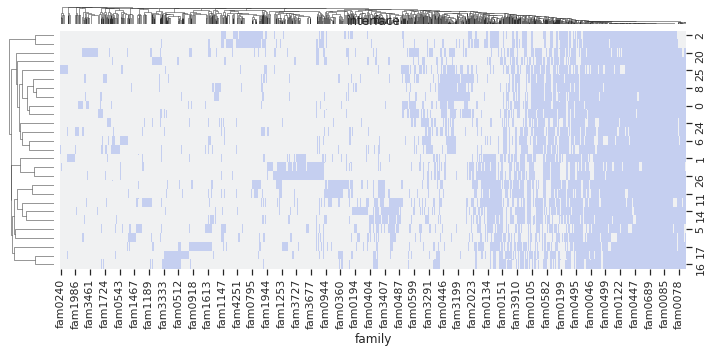

In [338]:
for category in metadata["category"].unique():
    
    # genomes to include
    genomes = metadata[metadata["category"]==category]["genome"].to_list()
    
    if len(genomes) > 5:
        
        pdf_dd_sub = pdf_dd[pdf_dd["bin"].isin(genomes)]
        piv = pdf_dd_sub.pivot("bin", "family", "value").fillna(0).reset_index().drop("bin", axis=1)
        g = sns.clustermap(piv, figsize=(10,5), row_cluster=True, method='average', 
            metric='jaccard', cmap=sns.light_palette("#c5cff0", as_cmap=True), cbar_pos = None, dendrogram_ratio=0.07)
        plt.title(category)